In [1]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import emcee
from scipy.optimize import minimize
import corner
import random
from IPython.display import display, Math
import dynesty
from dynesty import plotting as dyplot
from scipy.stats import uniform, loguniform
from dynesty import utils as dyfunc

In [6]:
data = np.load('transient.npy') 
#first column is time, the second column is the flux, 
#and the third column are homoescedastic measurement uncertainties on the flux
data.shape

(100, 3)

Text(0, 0.5, 'flux')

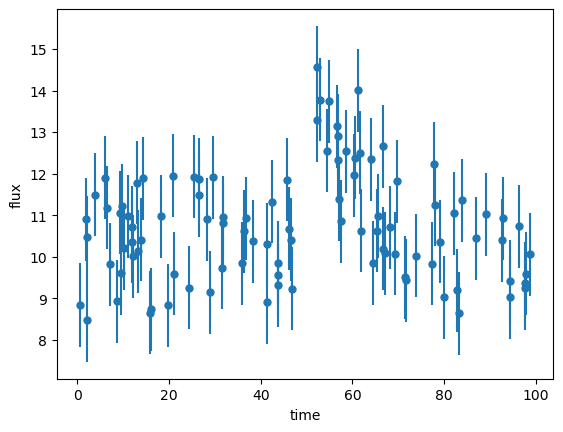

In [7]:
#plot data with uncertainties
time = data[:, 0]
flux = data[:, 1]
err_flux = data[:, 2]
plt.figure(dpi = 100)
plt.errorbar(time, flux, yerr=err_flux, fmt='o', ms=5)
plt.xlabel('time')
plt.ylabel('flux')

Definition of the two models: sharp burst with an exponential tail and Gaussian profile

In [8]:
def model_burst(t, theta):
    b, A, t0, alpha = theta
    result = np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))
    return result

def model_sigmaw(t, theta):
    b, A, t0, sigmaw = theta
    result = b + A * np.exp(-(t - t0)**2/2*sigmaw**2)
    return result

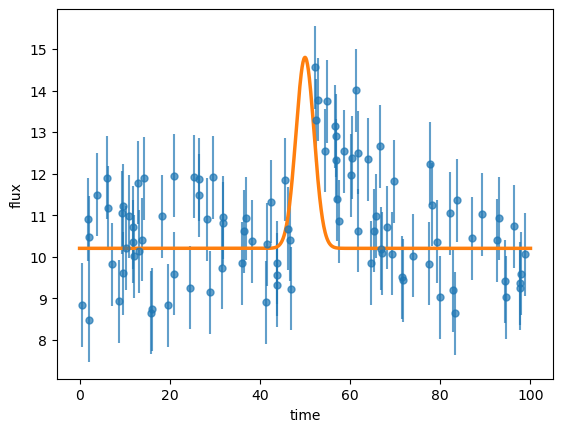

In [10]:
# SLOPPY FIT
tgrid=np.linspace(0,100,1000)
b_fit=10.2
A_fit=4.6
t0_fit=50
sigmaw_fit=0.5

theta_fit= np.array([b_fit,A_fit,t0_fit,sigmaw_fit])
ygrid =  model_sigmaw(tgrid, theta_fit)
plt.errorbar(time, flux, yerr=err_flux, alpha=0.7, fmt='o', ms=5)
plt.xlabel("time")
plt.ylabel("flux")
plt.plot(tgrid,ygrid, lw=2.5)
plt.show()  

In [11]:
bmin,bmax=0,50
Amin,Amax=0,50
t0min,t0max = 0,100
alphamin,alphamax=np.exp(-5),np.exp(5)
sigmawmin, sigmawmax= np.exp(-2.5),np.exp(2.5) #I have set sigmawmin as a small fraction of the standard deviation and sigmawmax to a larger multiple of the standard deviation
ndim = 4

Likelihood of the two models and definition of a uniform prior via the prior transform.

In [12]:
def log_likelihood(theta, x, y, sigma, model):
    b, A, t0, alpha = theta
    if model=='model_burst':
        ymodel=model_burst(x, theta)
    elif model=='model_sigmaw':
        ymodel=model_sigmaw(x, theta)
    return -0.5 * np.sum((y - ymodel) ** 2 / sigma**2)

# ppf=inverse of the cdf
"""Transforms samples `u` drawn from the unit cube to samples to those
    from our uniform prior within -interval/bounds- for each variable."""

def ptform(u, model): #b,A,t0,alpha
    x = np.array(u)
    x[0] = uniform(loc=bmin, scale=bmax-bmin).ppf(u[0]) #u[0], u[1], u[2], and u[3] represent the normalized values of b, A, t0, and alpha, respectively.
    x[1] = uniform(loc=Amin, scale=Amax-Amin).ppf(u[1]) #I used these normalized values as arguments to the ppf function for each parameter, transforming them to values within their respective bounds
    x[2] = uniform(loc=t0min, scale=t0max-t0min).ppf(u[2])
    if model=='model_burst':
        x[3] = loguniform.ppf(u[3], alphamin, alphamax) #ppf(q, a, b, loc=0, scale=1)
    elif model=='model_sigmaw':
        x[3] = loguniform.ppf(u[3], sigmawmin, sigmawmax)
    return x

Estimating the evidence and posterior:
1) "Static" nested sampling burst model

In [13]:
sampler = dynesty.NestedSampler(log_likelihood, ptform, ndim, logl_args=[time, flux, err_flux, 'model_burst'], ptform_args=['model_burst'], nlive=100)# It is crucial that the initial set of live points have been sampled from the prior
sampler.run_nested()
sresults = sampler.results  

C:\Users\Asus\AppData\Local\Temp\ipykernel_1472\515718041.py:3: RuntimeWarning: overflow encountered in exp
  result = np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))
C:\Users\Asus\AppData\Local\Temp\ipykernel_1472\515718041.py:3: RuntimeWarning: overflow encountered in multiply
  result = np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))
361it [00:11,  7.98it/s, bound: 0 | nc: 132 | ncall: 3698 | eff(%):  9.762 | loglstar:   -inf < -176.328 <    inf | logz: -184.959 +/-  0.282 | dlogz: 109.983 >  0.109]   C:\Users\Asus\AppData\Local\Temp\ipykernel_1472\515718041.py:3: RuntimeWarning: overflow encountered in exp
  result = np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))
373it [00:12, 21.82it/s, bound: 1 | nc: 1 | ncall: 3720 | eff(%): 10.027 | loglstar:   -inf < -155.188 <    inf | logz: -163.033 +/-  0.276 | dlogz: 87.037 >  0.109]   C:\Users\Asus\AppData\Local\Temp\ipykernel_1472\515718041.py:3: RuntimeWarning: overflow encountered in multiply
  result = np.where(t

574it [00:19, 11.25it/s, bound: 14 | nc: 15 | ncall: 5754 | eff(%):  9.976 | loglstar:   -inf < -89.353 <    inf | logz: -96.525 +/-  0.247 | dlogz: 38.303 >  0.109]C:\Users\Asus\AppData\Local\Temp\ipykernel_1472\515718041.py:3: RuntimeWarning: overflow encountered in exp
  result = np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))
C:\Users\Asus\AppData\Local\Temp\ipykernel_1472\515718041.py:3: RuntimeWarning: overflow encountered in multiply
  result = np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))
578it [00:20,  7.70it/s, bound: 15 | nc: 21 | ncall: 5935 | eff(%):  9.739 | loglstar:   -inf < -89.141 <    inf | logz: -96.347 +/-  0.248 | dlogz: 38.087 >  0.109]C:\Users\Asus\AppData\Local\Temp\ipykernel_1472\515718041.py:3: RuntimeWarning: overflow encountered in exp
  result = np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))
C:\Users\Asus\AppData\Local\Temp\ipykernel_1472\515718041.py:3: RuntimeWarning: overflow encountered in multiply
  result = np.where(t < t0, b,

C:\Users\Asus\AppData\Local\Temp\ipykernel_1472\515718041.py:3: RuntimeWarning: overflow encountered in multiply
  result = np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))
C:\Users\Asus\AppData\Local\Temp\ipykernel_1472\515718041.py:3: RuntimeWarning: overflow encountered in exp
  result = np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))
C:\Users\Asus\AppData\Local\Temp\ipykernel_1472\515718041.py:3: RuntimeWarning: overflow encountered in multiply
  result = np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))
722it [00:28,  5.39it/s, bound: 30 | nc: 70 | ncall: 8163 | eff(%):  8.845 | loglstar:   -inf < -87.179 <    inf | logz: -93.700 +/-  0.242 | dlogz: 33.969 >  0.109]C:\Users\Asus\AppData\Local\Temp\ipykernel_1472\515718041.py:3: RuntimeWarning: overflow encountered in exp
  result = np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))
725it [00:29,  7.17it/s, bound: 31 | nc: 35 | ncall: 8209 | eff(%):  8.832 | loglstar:   -inf < -87.175 <    inf | logz: -93.685 

785it [00:37,  4.37it/s, bound: 46 | nc: 43 | ncall: 10576 | eff(%):  7.422 | loglstar:   -inf < -87.091 <    inf | logz: -93.475 +/-  0.240 | dlogz: 33.114 >  0.109]C:\Users\Asus\AppData\Local\Temp\ipykernel_1472\515718041.py:3: RuntimeWarning: overflow encountered in exp
  result = np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))
786it [00:38,  3.57it/s, bound: 47 | nc: 130 | ncall: 10706 | eff(%):  7.342 | loglstar:   -inf < -87.090 <    inf | logz: -93.472 +/-  0.240 | dlogz: 34.728 >  0.109]C:\Users\Asus\AppData\Local\Temp\ipykernel_1472\515718041.py:3: RuntimeWarning: overflow encountered in multiply
  result = np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))
787it [00:38,  4.13it/s, bound: 47 | nc: 38 | ncall: 10744 | eff(%):  7.325 | loglstar:   -inf < -87.090 <    inf | logz: -93.470 +/-  0.240 | dlogz: 34.715 >  0.109] C:\Users\Asus\AppData\Local\Temp\ipykernel_1472\515718041.py:3: RuntimeWarning: overflow encountered in exp
  result = np.where(t < t0, b, b + A * 

C:\Users\Asus\AppData\Local\Temp\ipykernel_1472\515718041.py:3: RuntimeWarning: overflow encountered in exp
  result = np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))
C:\Users\Asus\AppData\Local\Temp\ipykernel_1472\515718041.py:3: RuntimeWarning: overflow encountered in multiply
  result = np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))
798it [00:46,  1.02s/it, bound: 63 | nc: 908 | ncall: 13114 | eff(%):  6.085 | loglstar:   -inf < -87.046 <    inf | logz: -93.446 +/-  0.240 | dlogz: 36.451 >  0.109]C:\Users\Asus\AppData\Local\Temp\ipykernel_1472\515718041.py:3: RuntimeWarning: overflow encountered in exp
  result = np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))
C:\Users\Asus\AppData\Local\Temp\ipykernel_1472\515718041.py:3: RuntimeWarning: overflow encountered in multiply
  result = np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))
C:\Users\Asus\AppData\Local\Temp\ipykernel_1472\515718041.py:3: RuntimeWarning: overflow encountered in exp
  result = np.where

C:\Users\Asus\anaconda3\lib\site-packages\dynesty\bounding.py:618: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
C:\Users\Asus\AppData\Local\Temp\ipykernel_1472\515718041.py:3: RuntimeWarning: overflow encountered in exp
  result = np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))
C:\Users\Asus\AppData\Local\Temp\ipykernel_1472\515718041.py:3: RuntimeWarning: overflow encountered in multiply
  result = np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))
803it [00:56,  1.76s/it, bound: 80 | nc: 344 | ncall: 15644 | eff(%):  5.133 | loglstar:   -inf < -86.943 <    inf | logz: -93.435 +/-  0.240 | dlogz: 36.391 >  0.109]C:\Users\Asus\A

822it [01:04,  2.19it/s, bound: 95 | nc: 247 | ncall: 17906 | eff(%):  4.591 | loglstar:   -inf < -86.581 <    inf | logz: -93.389 +/-  0.240 | dlogz: 36.156 >  0.109]C:\Users\Asus\AppData\Local\Temp\ipykernel_1472\515718041.py:3: RuntimeWarning: overflow encountered in exp
  result = np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))
C:\Users\Asus\AppData\Local\Temp\ipykernel_1472\515718041.py:3: RuntimeWarning: overflow encountered in multiply
  result = np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))
823it [01:05,  2.58it/s, bound: 96 | nc: 54 | ncall: 17960 | eff(%):  4.582 | loglstar:   -inf < -86.557 <    inf | logz: -93.387 +/-  0.240 | dlogz: 36.144 >  0.109] C:\Users\Asus\AppData\Local\Temp\ipykernel_1472\515718041.py:3: RuntimeWarning: overflow encountered in exp
  result = np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))
C:\Users\Asus\AppData\Local\Temp\ipykernel_1472\515718041.py:3: RuntimeWarning: overflow encountered in multiply
  result = np.where(t < t0

C:\Users\Asus\AppData\Local\Temp\ipykernel_1472\515718041.py:3: RuntimeWarning: overflow encountered in exp
  result = np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))
C:\Users\Asus\AppData\Local\Temp\ipykernel_1472\515718041.py:3: RuntimeWarning: overflow encountered in multiply
  result = np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))
C:\Users\Asus\AppData\Local\Temp\ipykernel_1472\515718041.py:3: RuntimeWarning: overflow encountered in exp
  result = np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))
C:\Users\Asus\AppData\Local\Temp\ipykernel_1472\515718041.py:3: RuntimeWarning: overflow encountered in multiply
  result = np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))
C:\Users\Asus\AppData\Local\Temp\ipykernel_1472\515718041.py:3: RuntimeWarning: overflow encountered in exp
  result = np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))
C:\Users\Asus\AppData\Local\Temp\ipykernel_1472\515718041.py:3: RuntimeWarning: overflow encountered in multiply
  resul

C:\Users\Asus\AppData\Local\Temp\ipykernel_1472\515718041.py:3: RuntimeWarning: overflow encountered in exp
  result = np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))
C:\Users\Asus\AppData\Local\Temp\ipykernel_1472\515718041.py:3: RuntimeWarning: overflow encountered in multiply
  result = np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))
C:\Users\Asus\AppData\Local\Temp\ipykernel_1472\515718041.py:3: RuntimeWarning: overflow encountered in exp
  result = np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))
C:\Users\Asus\AppData\Local\Temp\ipykernel_1472\515718041.py:3: RuntimeWarning: overflow encountered in multiply
  result = np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))
C:\Users\Asus\AppData\Local\Temp\ipykernel_1472\515718041.py:3: RuntimeWarning: overflow encountered in exp
  result = np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))
C:\Users\Asus\AppData\Local\Temp\ipykernel_1472\515718041.py:3: RuntimeWarning: overflow encountered in multiply
  resul

894it [01:34,  6.58it/s, bound: 153 | nc: 96 | ncall: 26536 | eff(%):  3.369 | loglstar:   -inf < -81.189 <    inf | logz: -91.785 +/-  0.292 | dlogz: 33.889 >  0.109]C:\Users\Asus\AppData\Local\Temp\ipykernel_1472\515718041.py:3: RuntimeWarning: overflow encountered in exp
  result = np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))
899it [01:34,  8.00it/s, bound: 154 | nc: 53 | ncall: 26669 | eff(%):  3.371 | loglstar:   -inf < -80.989 <    inf | logz: -91.528 +/-  0.295 | dlogz: 33.577 >  0.109]C:\Users\Asus\AppData\Local\Temp\ipykernel_1472\515718041.py:3: RuntimeWarning: overflow encountered in exp
  result = np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))
901it [01:34,  9.58it/s, bound: 154 | nc: 5 | ncall: 26698 | eff(%):  3.375 | loglstar:   -inf < -80.856 <    inf | logz: -91.431 +/-  0.297 | dlogz: 33.458 >  0.109] C:\Users\Asus\AppData\Local\Temp\ipykernel_1472\515718041.py:3: RuntimeWarning: overflow encountered in multiply
  result = np.where(t < t0, b, b + A *

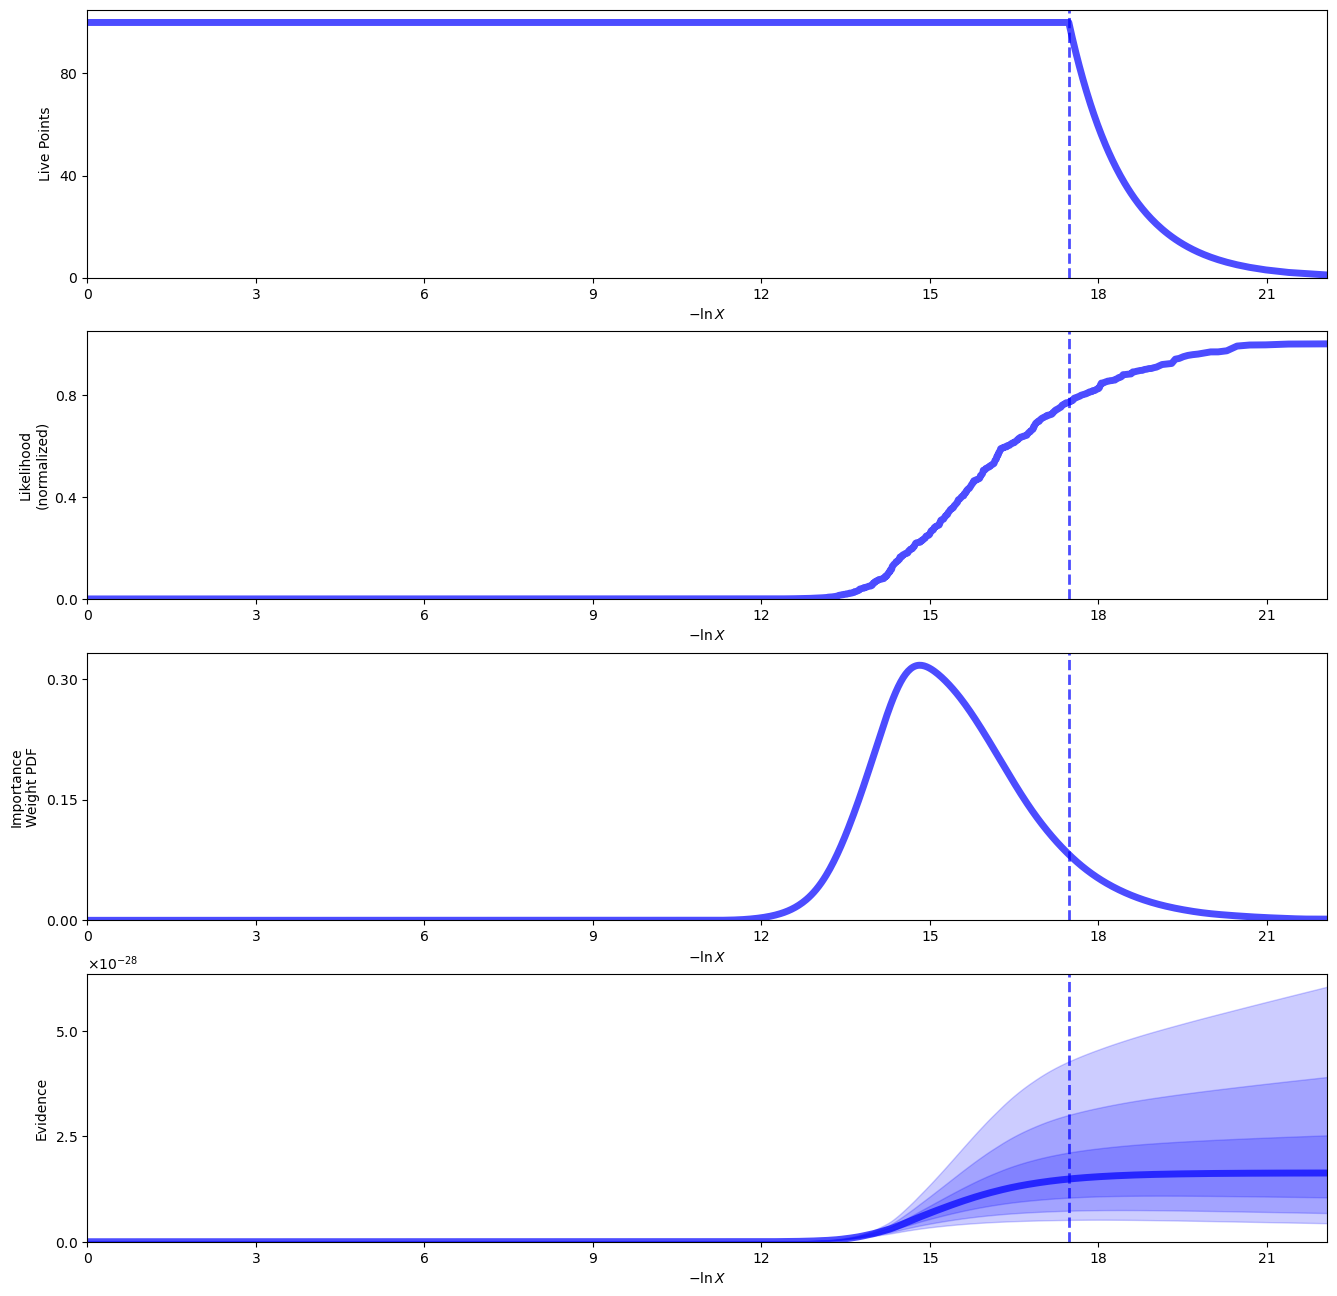

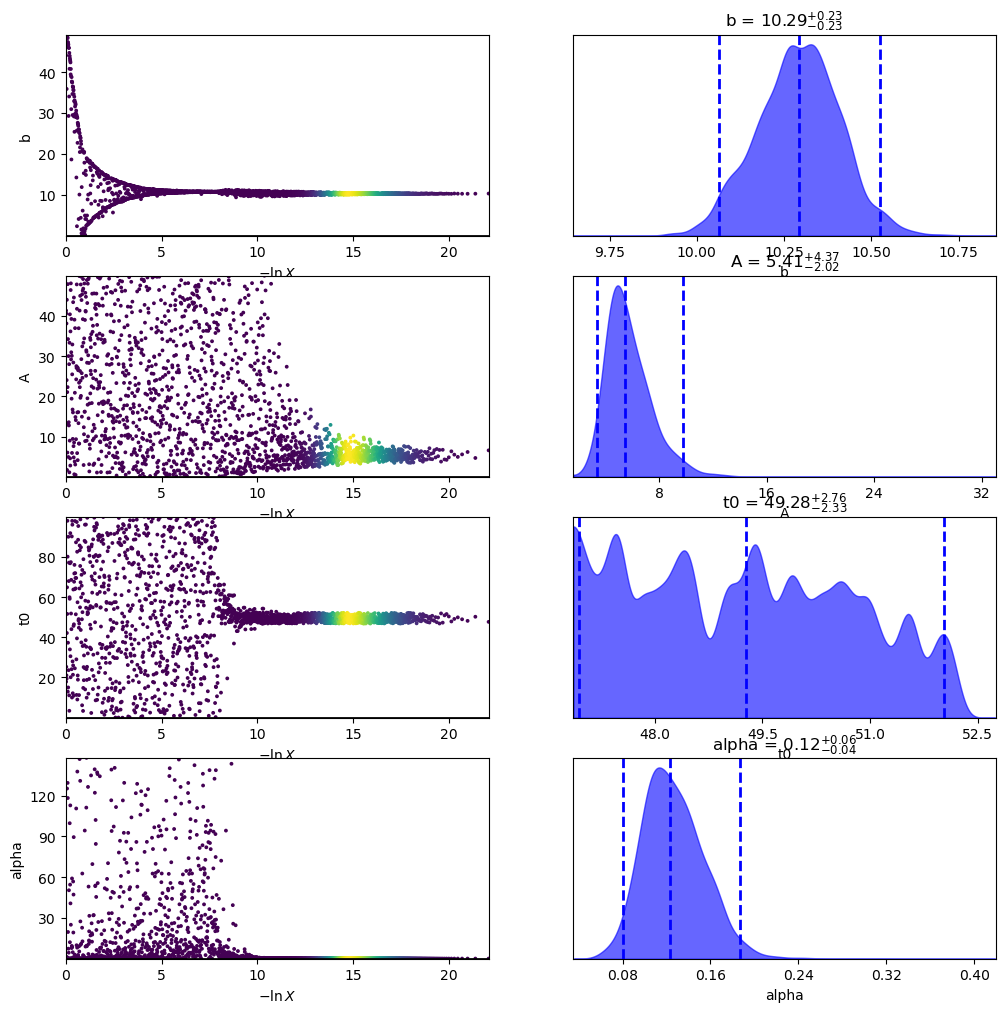

In [15]:
rfig, raxes = dyplot.runplot(sresults) 

fig, axes = dyplot.traceplot(sresults, truths=np.zeros(ndim), labels=['b', 'A', 't0','alpha'],
                             truth_color='black', show_titles=True,
                             trace_cmap='viridis', connect=False,
                             connect_highlight=range(5))


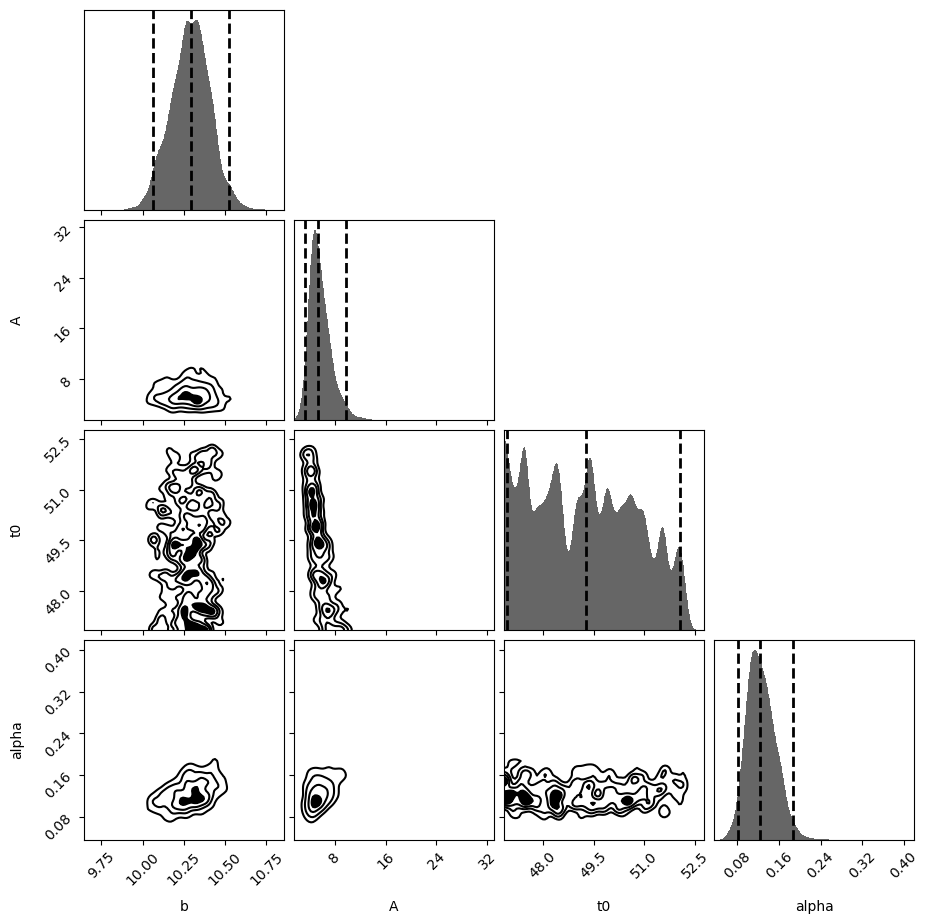

In [16]:
cfig, caxes = dyplot.cornerplot(sresults, labels=['b', 'A', 't0','alpha'] )

In [17]:
sresults.summary()

Summary
nlive: 100
niter: 1755
ncall: 35609
eff(%):  5.209
logz: -63.983 +/-  0.437


In [20]:
samples = sresults.samples  # samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  # normalized weights
evidence = sresults.logz[-1] #evidence
print("Bayesian evidence", np.exp(evidence))
quantiles = [dyfunc.quantile(samps, [0.05, 0.25, 0.5, 0.75, 0.95], weights=weights)
             for samps in samples.T]
parameters = ['b', 'A', 't0', 'alpha']
credible_regions = {param: quant for param, quant in zip(parameters, quantiles)}

print('Parameter percentiles (5th, 25th, 50th, 75th, 95th) are:')
for param, quant in credible_regions.items():
    print(f'{param}: {quant}')

Bayesian evidence 1.6319364427963225e-28
Parameter percentiles (5th, 25th, 50th, 75th, 95th) are:
b: [10.08543366756174, 10.210887004353607, 10.293791341623571, 10.370167220021003, 10.477892789551957]
A: [3.675460803739075, 4.5487467215510025, 5.411680533128719, 6.61424703251832, 8.861580160188518]
t0: [47.023333480460344, 47.97065953287464, 49.27570067029433, 50.510486260164654, 51.85801772077696]
alpha: [0.08709724869117368, 0.10662715891865784, 0.12299235029709506, 0.14375856403478385, 0.17197818814962942]


(1912, 4)

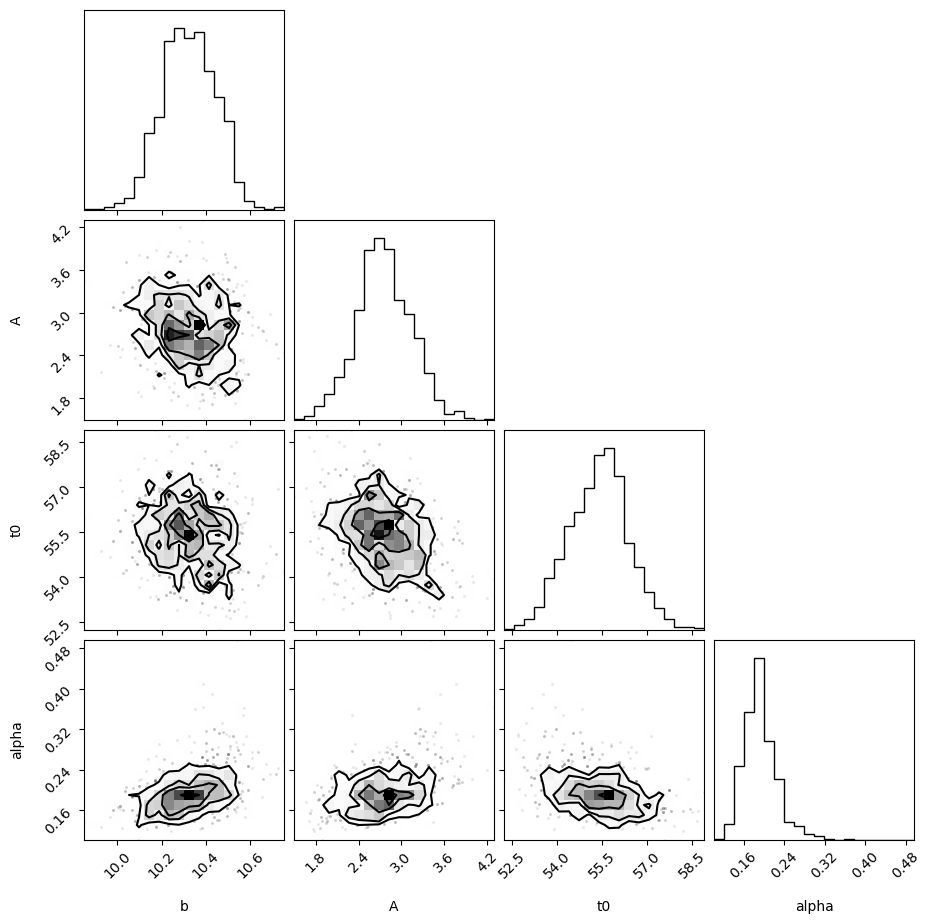

In [60]:
samples_equal = dyfunc.resample_equal(samples, weights)
labels = ['b', 'A', 't0', 'alpha']
corner.corner(samples_equal,labels=labels);
samples_equal.shape

In [61]:
mean = np.mean(samples_equal, axis=0)

# Compute the covariance matrix of the samples
covariance_matrix = np.cov(samples_equal, rowvar=False)

print("Mean:\n", mean)
print("Covariance Matrix:\n", covariance_matrix)

Mean:
 [10.321797    2.75353166 55.39007723  0.1934534 ]
Covariance Matrix:
 [[ 0.01440835 -0.00933131 -0.02098461  0.00182414]
 [-0.00933131  0.14739712 -0.12478796  0.00465144]
 [-0.02098461 -0.12478796  0.9701174  -0.01304837]
 [ 0.00182414  0.00465144 -0.01304837  0.0011687 ]]


2) "Static" nested sampling Gaussian model

In [64]:
sampler = dynesty.NestedSampler(log_likelihood, ptform, ndim, logl_args=[time, flux, err_flux, 'model_sigmaw'],ptform_args=['model_sigmaw'], nlive=300)# It is crucial that the initial set of live points have been sampled from the prior
sampler.run_nested()
sresults2 = sampler.results                               

2549it [04:55,  2.79s/it, bound: 65 | nc: 68 | ncall: 40050 | eff(%):  6.365 | loglstar:   -inf < -86.532 <    inf | logz: -94.445 +/-  0.150 | dlogz: 29.922 >  0.309]     C:\Users\Asus\anaconda3\lib\site-packages\dynesty\bounding.py:618: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
2559it [05:26,  2.56s/it, bound: 75 | nc: 60 | ncall: 44291 | eff(%):  5.778 | loglstar:   -inf < -86.450 <    inf | logz: -94.426 +/-  0.150 | dlogz: 29.870 >  0.309]  C:\Users\Asus\anaconda3\lib\site-packages\dynesty\bounding.py:618: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using un

2916it [08:06,  4.26it/s, bound: 122 | nc: 34 | ncall: 65767 | eff(%):  4.434 | loglstar:   -inf < -78.003 <    inf | logz: -89.414 +/-  0.186 | dlogz: 26.296 >  0.309] C:\Users\Asus\anaconda3\lib\site-packages\dynesty\bounding.py:618: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
2944it [08:24,  5.27it/s, bound: 127 | nc: 13 | ncall: 68031 | eff(%):  4.327 | loglstar:   -inf < -77.448 <    inf | logz: -88.931 +/-  0.186 | dlogz: 25.720 >  0.309] C:\Users\Asus\anaconda3\lib\site-packages\dynesty\bounding.py:618: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using unifo

3052it [10:32,  3.66s/it, bound: 166 | nc: 113 | ncall: 85564 | eff(%):  3.567 | loglstar:   -inf < -74.842 <    inf | logz: -86.859 +/-  0.189 | dlogz: 23.292 >  0.309] C:\Users\Asus\anaconda3\lib\site-packages\dynesty\bounding.py:618: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
3054it [10:35,  2.46s/it, bound: 167 | nc: 142 | ncall: 85925 | eff(%):  3.554 | loglstar:   -inf < -74.743 <    inf | logz: -86.814 +/-  0.189 | dlogz: 23.241 >  0.309]C:\Users\Asus\anaconda3\lib\site-packages\dynesty\bounding.py:618: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using unif

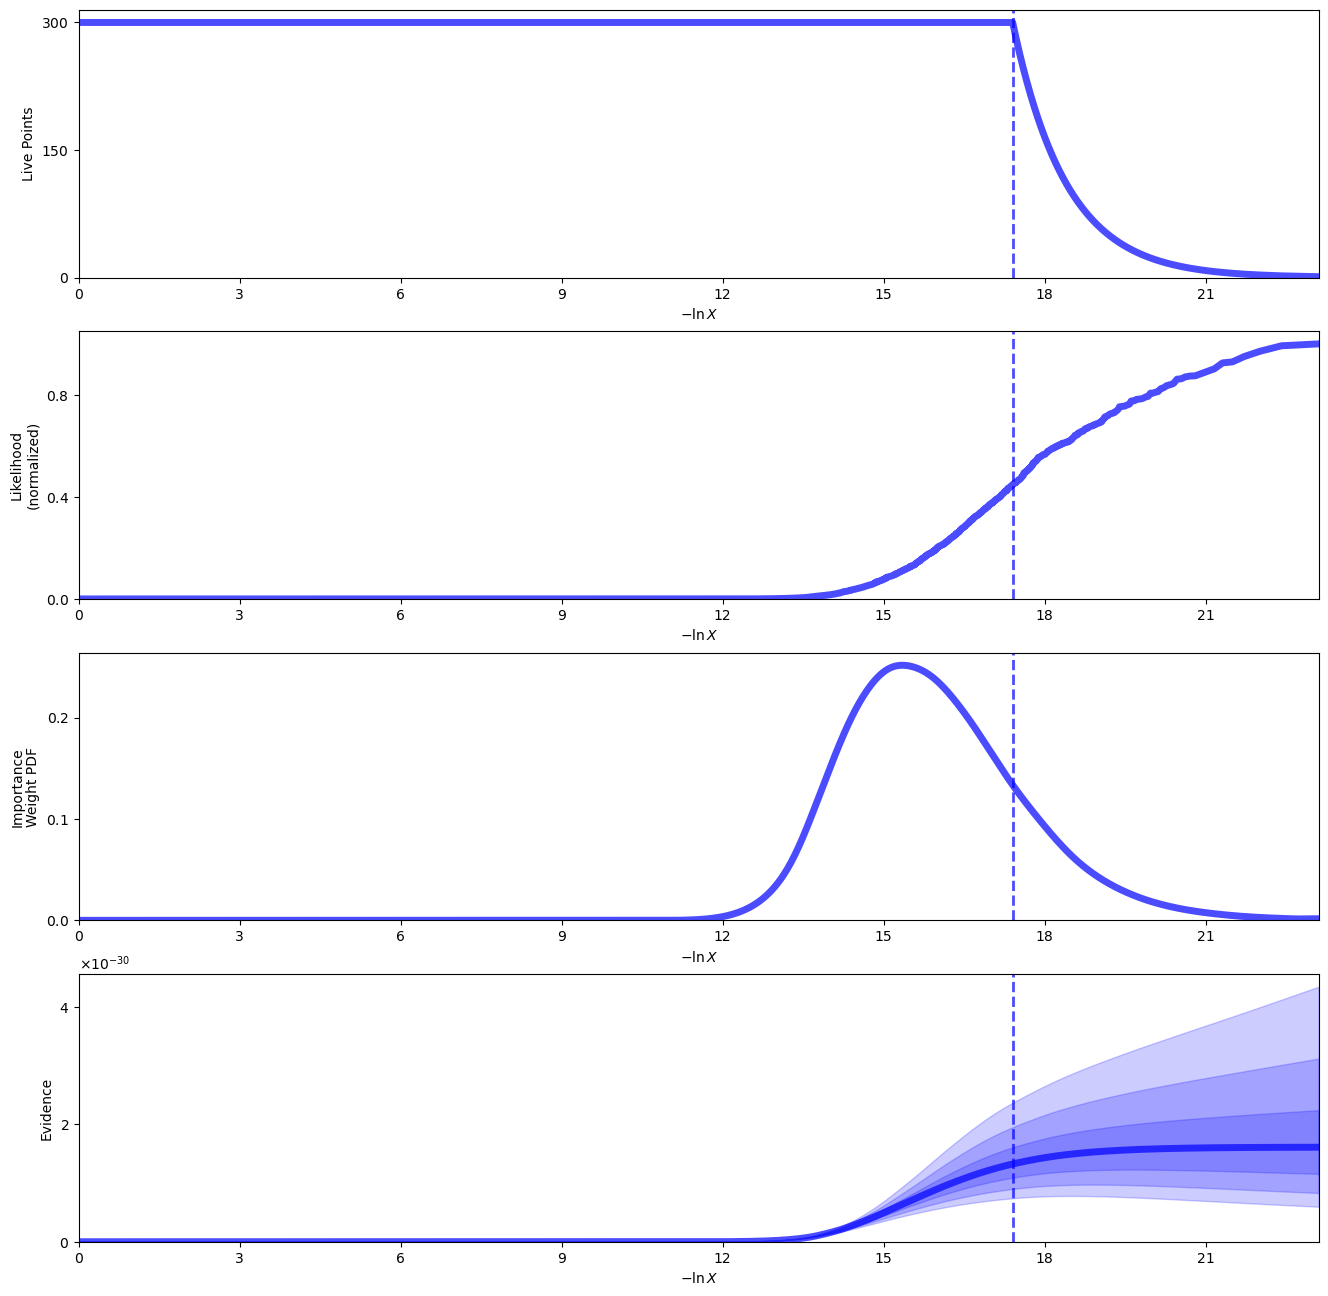

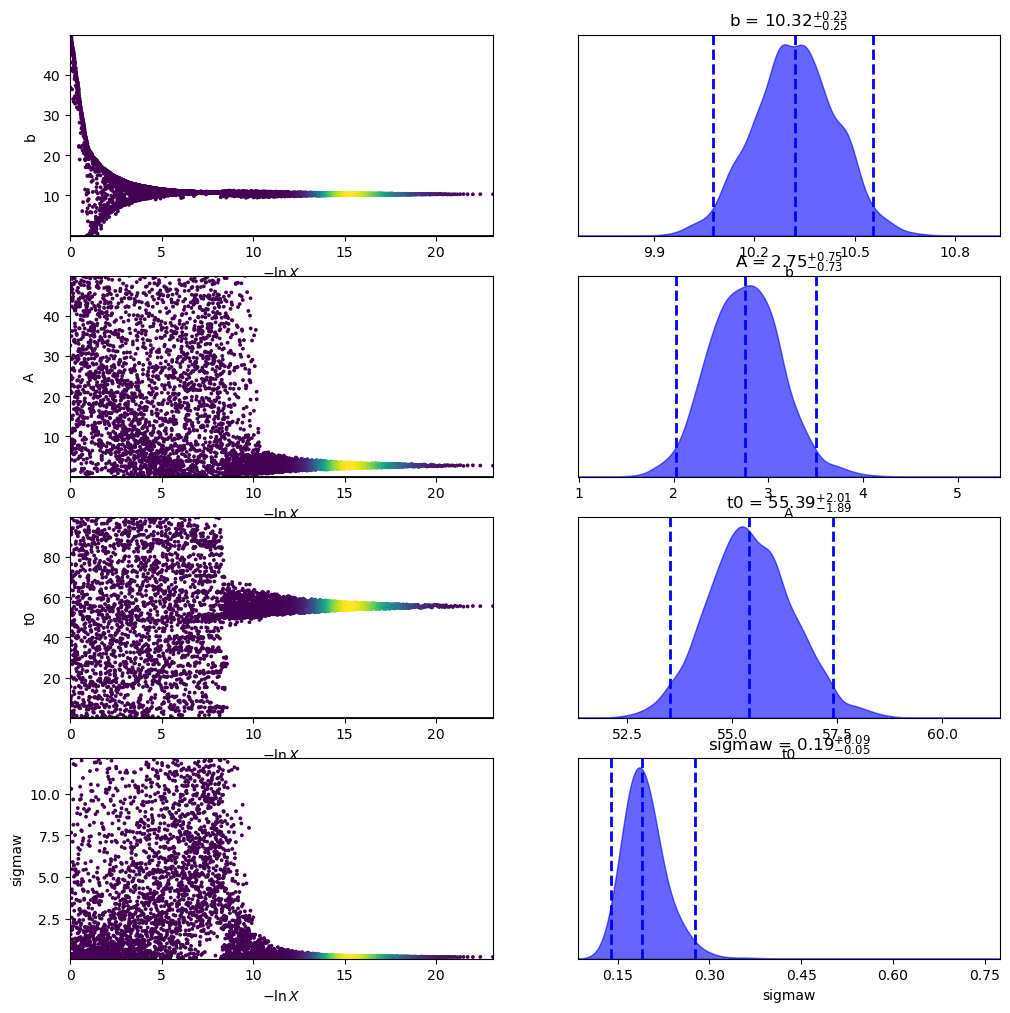

In [66]:
rfig, raxes = dyplot.runplot(sresults2) 

fig, axes = dyplot.traceplot(sresults2, truths=np.zeros(ndim), labels=['b', 'A', 't0','sigmaw'],
                             truth_color='black', show_titles=True,
                             trace_cmap='viridis', connect=False,
                             connect_highlight=range(5))

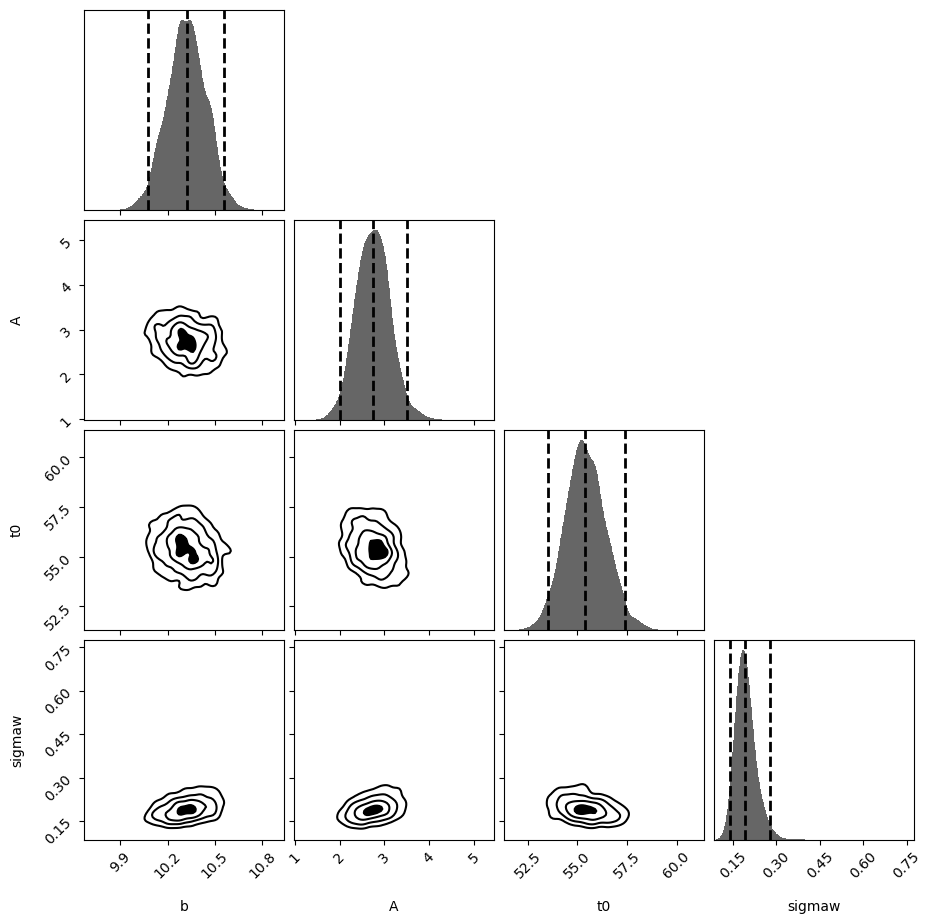

In [65]:
cfig, caxes = dyplot.cornerplot(sresults2, labels=['b', 'A', 't0','sigmaw'] )


In [67]:
sresults2.summary()

Summary
nlive: 300
niter: 5229
ncall: 93705
eff(%):  5.900
logz: -68.600 +/-  0.331


In [68]:
samples2 = sresults2.samples  # samples
weights = np.exp(sresults2.logwt - sresults2.logz[-1])  # normalized weights
evidence = sresults2.logz[-1] #evidence
print("Bayesian evidence", np.exp(evidence))
quantiles = [dyfunc.quantile(samps, [0.05, 0.25, 0.5, 0.75, 0.95], weights=weights)
             for samps in samples2.T]
parameters = ['b', 'A', 't0', 'alpha']
credible_regions = {param: quant for param, quant in zip(parameters, quantiles)}

print('Parameter percentiles (5th, 25th, 50th, 75th, 95th) are:')
for param, quant in credible_regions.items():
    print(f'{param}: {quant}')

Bayesian evidence 1.611468382271583e-30
Parameter percentiles (5th, 25th, 50th, 75th, 95th) are:
b: [10.118695322022905, 10.237993854574892, 10.322538587967106, 10.403447502359263, 10.51582848690191]
A: [2.1605616572146875, 2.4921321903938614, 2.7513094880112554, 3.0100117312787433, 3.3815361105382684]
t0: [53.80672268637736, 54.74623779264871, 55.394704520591986, 56.08130361195527, 57.16844541048701]
alpha: [0.14653197163601156, 0.17095322124517162, 0.19026670623264047, 0.21175176917966793, 0.2582776247118819]


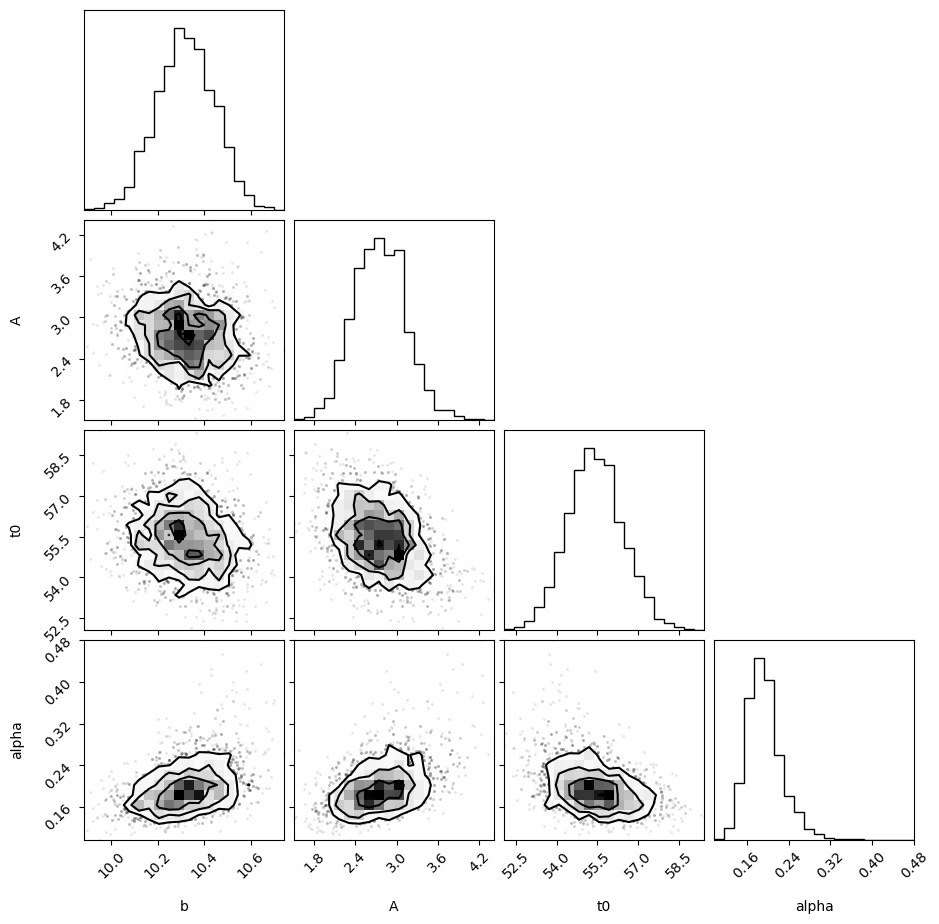

In [69]:
samples_equal2 = dyfunc.resample_equal(samples2, weights)
labels = ['b', 'A', 't0', 'alpha']
corner.corner(samples_equal2, labels=labels);

In [70]:
mean2 = np.mean(samples_equal2, axis=0)

# Compute the covariance matrix of the samples
covariance_matrix2 = np.cov(samples_equal2, rowvar=False)

print("Mean:\n", mean2)
print("Covariance Matrix:\n", covariance_matrix2)

Mean:
 [10.319551    2.75477395 55.4265801   0.19455281]
Covariance Matrix:
 [[ 0.01527117 -0.00863449 -0.02336687  0.00165197]
 [-0.00863449  0.1442615  -0.13081532  0.00558637]
 [-0.02336687 -0.13081532  1.03212538 -0.01383308]
 [ 0.00165197  0.00558637 -0.01383308  0.00128625]]


BAYES FACTOR: Jeffrey's scale. the ratio between the marginal likelihood of two models. The larger the BF the better the model in the numerator

In [75]:
BF= np.exp(sresults.logz[-1])/np.exp(sresults2.logz[-1])
print('Bayes factor= ', np.log(BF)) # -> "very strong"/"decisive" evidence in favour of the burst model


Bayes factor=  4.617791695386849
